In [1]:
import os
import sqlite3

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['LOKY_MAX_CPU_COUNT'] = '6'
%matplotlib inline

In [2]:
offers_connection = sqlite3.connect('../datasets/offers_full.db')
offers_frame = pd.read_sql_query('''SELECT * FROM offers''', offers_connection)
offers_connection.close()

offers_frame.dropna(subset='Name',inplace=True)
offers_frame.drop_duplicates(inplace=True)

# Convert RequiredSkills to set
def string_to_set(item_set):
     return set(item_set.split(', '))
offers_frame['RequiredSkills'] = offers_frame['RequiredSkills'].apply(string_to_set)

offers_frame

,Name,Description,Location,RequiredSkills,LocationType,Languages,Latitude,Longitude
0,Software Developer,Miniclip is a global leader in digital games w...,"Genova, Liguria","{100, 101}",OnSite,inglese,44.405650,8.946256
1,Junior Software Developer,"NETtoWORK, azienda italiana nata nel 2016, ope...",17100 Savona,"{9, 8, 7, 6, 2}",OnSite,italiano,44.342550,8.429389
2,Software Developer,We are looking for talented and passionate peo...,55100 Lucca,"{26, 0, 6, 44}",OnSite,inglese,43.842920,10.502698
3,Software Developer,ARESYS is a R&D oriented company with nearly ...,"Matera, Basilicata","{2, 9, 8}",OnSite,inglese,40.666379,16.604320
4,Senior Software Developer,Il/la Candidato/a dovrà padroneggiare: \n \n- ...,"Catania, Sicilia","{26, 57, 7, 6, 99, 1, 0, 104}",OnSite,italiano,37.507877,15.083030
...,...,...,...,...,...,...,...,...
473,IT On-Site Support Engineer,IT On-Site Support EngineerFunctional area: In...,"Milano, Lombardia",{103},OnSite,"inglese, italiano",45.464204,9.189982
474,Python Software Engineer,Now is an amazing time to join Nozomi Networks...,"Milano, Lombardia","{2, 30, 73, 89}",OnSite,inglese,45.464204,9.189982
475,Software Engineer,"Who we are:At Mambu, we believe that banking a...","Provincia di Latina, Lazio","{31, 30, 6}",OnSite,inglese,41.408748,13.081790
476,Workspace & Endpoint Deployment - System Engineer,Intesa Sanpaolo è un gruppo bancario internazi...,"Milano, Lombardia",{103},OnSite,"inglese, italiano",45.464204,9.189982


## Distance Matrix 

In [3]:
from commons import (
    get_distance_matrix,
    kmeans_silhouette
)

distance_matrix = get_distance_matrix(offers_frame, 'RequiredSkills')
distance_matrix

,0,1,2,3,4,5,6,7,8,9,...,468,469,470,471,472,473,474,475,476,477
0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.666667,1.000000,1.000000,...,1.00,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000
1,1.0,0.000000,0.875000,0.400000,0.818182,0.833333,0.600000,1.000000,1.000000,0.833333,...,1.00,0.875000,0.777778,0.928571,0.833333,1.0,0.875000,0.857143,1.0,1.000
2,1.0,0.875000,0.000000,1.000000,0.666667,0.800000,0.800000,1.000000,0.833333,0.800000,...,0.80,1.000000,1.000000,0.923077,1.000000,1.0,1.000000,0.833333,1.0,1.000
3,1.0,0.400000,1.000000,0.000000,1.000000,1.000000,0.750000,1.000000,1.000000,1.000000,...,1.00,0.833333,0.714286,0.916667,0.750000,1.0,0.833333,1.000000,1.0,1.000
4,1.0,0.818182,0.666667,1.000000,0.000000,0.750000,0.888889,1.000000,0.625000,0.888889,...,0.75,0.909091,1.000000,0.714286,1.000000,1.0,1.000000,0.900000,1.0,0.875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.00,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,0.0,1.000
474,1.0,0.875000,1.000000,0.833333,1.000000,1.000000,0.800000,1.000000,1.000000,1.000000,...,1.00,0.857143,0.750000,0.833333,0.500000,1.0,0.000000,0.833333,1.0,1.000
475,1.0,0.857143,0.833333,1.000000,0.900000,0.750000,0.750000,1.000000,1.000000,0.750000,...,1.00,1.000000,0.714286,0.916667,0.750000,1.0,0.833333,0.000000,1.0,1.000
476,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.00,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,0.0,1.000


## Clustering 

Nella sezione qui di seguito vengono effettuati degli esperimenti con diversi algoritmi di Clustering, per valutare i risultati useremo il **Silhouette Score**, questo perchè fornisce più dettagli riguardo alle relazioni, in particolare la separazione, tra cluster.

Per interpretare i risultati del Silhouette Score è importante notare che i valori, che variano da -1 a +1 hanno i seguenti significati:
-  1: Gli Item sono assegnati a un cluster specifico e i cluster sono facilmente distinguibili.
-  0: I cluster si sovrappongono.
- -1: Gli Item vengono assegnati a cluster errati.

### KMeans


In [4]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.cluster import KMeans


def evaluate_clustering(k):
    tmp_kmeans = KMeans(n_clusters=k, init='k-means++', n_init=5, random_state=42)
    tmp_labels = tmp_kmeans.fit_predict(distance_matrix)
    offers_frame['Group'] = tmp_labels
    
    score = kmeans_silhouette(offers_frame, tmp_kmeans)
    return score, k

# --- See how many clusters perform the best
max_value = -2
best_value = 0
with ThreadPoolExecutor(max_workers=4) as executor:
    futures = [executor.submit(evaluate_clustering, k) for k in range(3, 7)]
    for future in as_completed(futures):
        try:
            value, k = future.result()
            print(f'Score for {k}: {value:.3f}')
            if value > max_value:
                best_value = k
                max_value = value
        except Exception as something:
            import traceback
            traceback.print_exc()
            print(f'Something went wrong: {something}')
            break


Score for 3: 0.012
Score for 4: 0.017
Score for 5: 0.020
Score for 6: 0.008


### Birch

Dati gli scarsi risultati con il KMeans è stata effettuata una ricerca di algoritmi più adatti, i primi miglioramenti sono stati ottenuti con il Birch (...), nonostante ciò il margine di miglioramento era ancora alto. 

Un problema potrebbe essere la dimensione della Distance Matrix, infatti anche se il Birch è più flessibile, in generale gli algoritmi di clustering non lavorano bene su dati con molte dimensioni, che tra l'altro sono destinate ad aumentare con l'aggiunta di nuove offerte nel sistema; l'intuizione è quindi stata quella di applicare una tecnica di riduzione delle dimensionalità chiamata **Principal Component Analysis** (che avevamo già esplorato per effettuare la visualizzazione mostrata di seguito).


**Base**

In [5]:
from sklearn.cluster import Birch
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score


def birch_silhouette_scorer(model, data):
    tmp_labels = model.fit_predict(data)
    score = silhouette_score(data, tmp_labels)
    return score

param_grid = {
    'n_clusters': [3, 4, 5, 6],
    'threshold': [0.5, 0.7, 0.8],
    'branching_factor': [50, 100]
}
gsearch_base = GridSearchCV(Birch(), param_grid, cv=5, scoring=birch_silhouette_scorer, n_jobs=-1)
gsearch_base.fit(distance_matrix)

print(f"Best Parameters with Distance Matrix: {gsearch_base.best_params_}")
print(f"Best Silhouette Score with Distance Matrix: {gsearch_base.best_score_:.2f}")

Best Parameters with Distance Matrix: {'branching_factor': 50, 'n_clusters': 3, 'threshold': 0.7}
Best Silhouette Score with Distance Matrix: 0.20


**Dimensionality Reduction**

In [6]:
from sklearn.decomposition import PCA


_pca = PCA(2)
_data = _pca.fit_transform(distance_matrix)

gsearch_pca = GridSearchCV(Birch(), param_grid, cv=5, scoring=birch_silhouette_scorer, n_jobs=-1)
gsearch_pca.fit(_data)

print(f"Best Parameters: {gsearch_pca.best_params_}")
print(f"Best Silhouette Score: {gsearch_pca.best_score_:.2f}")

Best Parameters: {'branching_factor': 50, 'n_clusters': 3, 'threshold': 0.7}
Best Silhouette Score: 0.47


**Test**

In [7]:
from sklearn.model_selection import train_test_split


X_train, X_test = train_test_split(distance_matrix, test_size=0.2, random_state=42)
_train_data = _pca.fit_transform(X_train)
_test_data = _pca.transform(X_test)
print(f'Train Size: {len(_train_data)}; Test Size: {len(_test_data)}')

gsearch_test = GridSearchCV(Birch(), param_grid, cv=5, scoring=birch_silhouette_scorer, n_jobs=-1)
gsearch_test.fit(_train_data)

brc_test = Birch(
    n_clusters=gsearch_test.best_params_['n_clusters'], 
    threshold=gsearch_test.best_params_['threshold'], 
    branching_factor=gsearch_test.best_params_['branching_factor']
)
brc_test.fit(_train_data)
test_labels = brc_test.predict(_test_data)
test_score = silhouette_score(_test_data, test_labels)
print(f"Test Silhouette Score: {test_score:.2f}")

Train Size: 382; Test Size: 96
Test Silhouette Score: 0.45


**Risultati**

Di seguito viene mostrato il progresso tra i risultati ottenuti con il KMeans fino all'ultimo modello proposto.

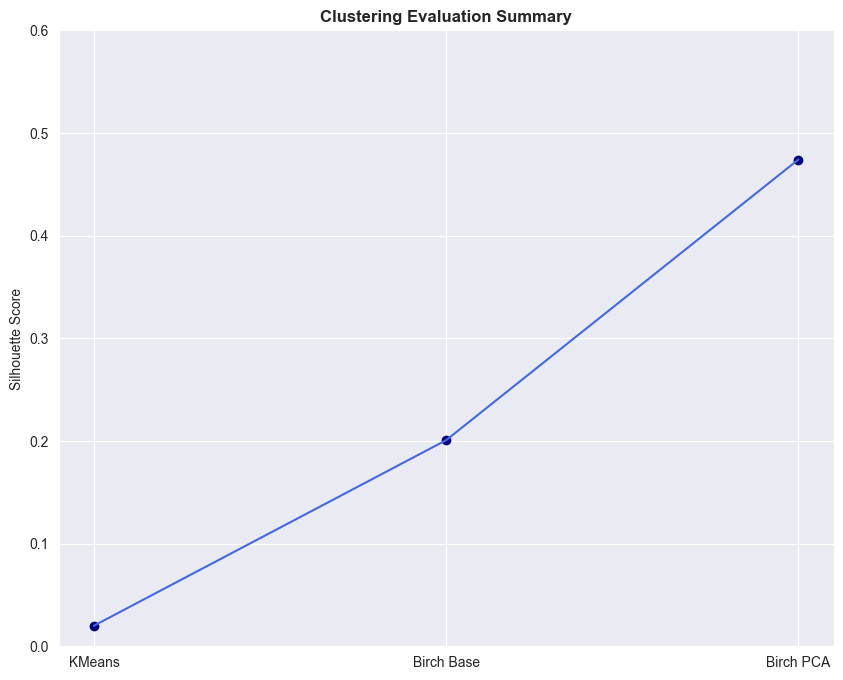

In [8]:
results = {
    'KMeans': max_value,
    'Birch Base': gsearch_base.best_score_,
    'Birch PCA': gsearch_pca.best_score_
}
plt.figure(figsize=(10,8))
plt.title('Clustering Evaluation Summary', fontweight='bold')
plt.ylabel('Silhouette Score')
plt.ylim(0, +0.6)

sns.lineplot(x=results.keys(), y=results.values(), color='royalblue')

for key, value in results.items():
    plt.scatter([key], [value], color='navy')

plt.show()

### Modello Finale

Visualizzare i risultati è importante per poter trarre delle conclusioni sulla qualità del clustering, la natura dei dati che bisogna visualizzare è però multidimensionale, questo può rendere arduo effettuare un plot; analizzando il problema possiamo dire che il nostro obbiettivo è *poter associare delle coordinate (x, y) a ogni Offerta nel dataset*, in particolare sfruttando la matrice delle distanze.
Per fare ciò useremo la riduzione delle dimensionalità tramite **Principal Component Analysis**. 

In [9]:
_final_data = _pca.fit_transform(distance_matrix)

brc = Birch(
    n_clusters=gsearch_pca.best_params_['n_clusters'], 
    threshold=gsearch_pca.best_params_['threshold'], 
    branching_factor=gsearch_pca.best_params_['branching_factor']
)
brc.fit(_final_data)
labels = brc.labels_
offers_frame['Group'] = labels

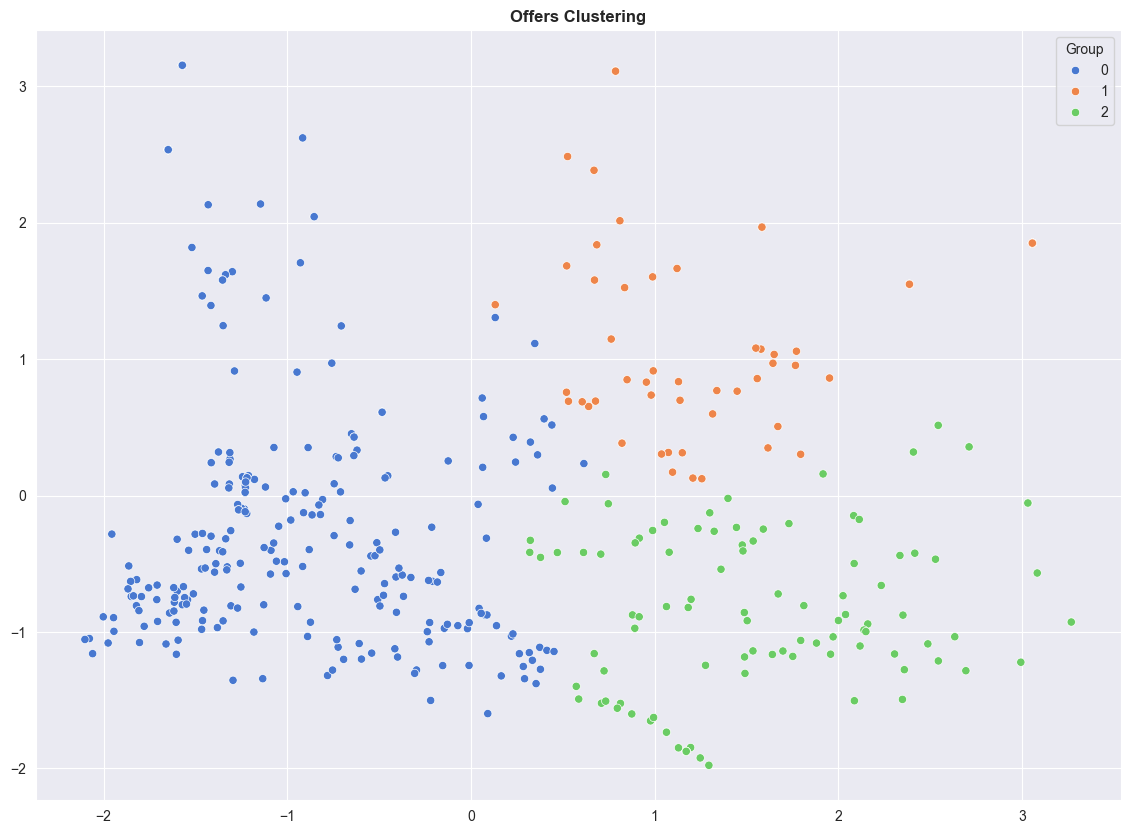

In [10]:
from sklearn.decomposition import PCA


pca = PCA(2)
group_labels = offers_frame['Group']
reduced_data = pca.fit_transform(distance_matrix)

plt.figure(figsize=(14, 10))
sns.scatterplot(x=reduced_data[:,0], y=reduced_data[:,1], hue=group_labels, palette='muted')
plt.title('Offers Clustering', fontweight='bold')

plt.show()